In [1]:
!git clone https://github.com/nilrema/TraffiKING.git

Cloning into 'TraffiKING'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 195 (delta 3), reused 2 (delta 2), pack-reused 188 (from 4)
Receiving objects: 100% (195/195), 539.13 MiB | 20.17 MiB/s, done.
Resolving deltas: 100% (59/59), done.
Updating files: 100% (36/36), done.


In [1]:
from pathlib import Path
import os

USING_COLAB = False
PREFIX = Path('/content/TraffiKING') if USING_COLAB else Path('')

if USING_COLAB:
    os.chdir(PREFIX)
else:
    import torch
    # os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    torch.cuda.set_device(0)

## Dataset


In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Downloadanje

In [5]:
import kagglehub

# Download latest version
path1 = kagglehub.dataset_download('meowmeowmeowmeowmeow/gtsrb-german-traffic-sign')

print("Path to dataset files:", path1)


# Download latest version
path2 = kagglehub.dataset_download('valentynsichkar/traffic-signs-1-million-images-for-classification')

print("Path to dataset files:", path2)

100%|██████████| 612M/612M [00:18<00:00, 34.9MB/s] 

Extracting files...


Path to dataset files: /home/vmoskov/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


100%|██████████| 20.1G/20.1G [13:17<00:00, 27.0MB/s]  

Extracting files...


Path to dataset files: /home/vmoskov/.cache/kagglehub/datasets/valentynsichkar/traffic-signs-1-million-images-for-classification/versions/3


### Kopiranje u Colab folder

In [11]:
import shutil

# Source and destination paths
paths = [Path(path1), Path(path2)]

for source_path in paths:
    # Copy the directory recursively
    destination_path = PREFIX / 'datasets' / source_path.parent.parent.name
    try:
        shutil.copytree(source_path, destination_path)
        print(f"Successfully copied from {source_path} to {destination_path}")
    except FileExistsError:
        print(f"Destination directory '{destination_path}' already exists.")
    except Exception as e:
        print(f"Error occurred: {e}")

Successfully copied from /home/vmoskov/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1 to datasets/gtsrb-german-traffic-sign
Successfully copied from /home/vmoskov/.cache/kagglehub/datasets/valentynsichkar/traffic-signs-1-million-images-for-classification/versions/3 to datasets/traffic-signs-1-million-images-for-classification


## Priprema podataka

### Učitavanje podataka

In [3]:
import os
import cv2
import numpy as np

train_folder = PREFIX / 'datasets' / 'gtsrb-german-traffic-sign' / 'Train'
categories = 43
image_size = (64, 64)

train_images = []
train_labels = []

for label in range(categories):
    category_path = os.path.join(train_folder, str(label)) # folder path
    image_files = os.listdir(category_path)

    for image_file in image_files:
        image_path = os.path.join(category_path, image_file)
        image = cv2.imread(image_path)

        if image is not None:
            image = cv2.resize(image, image_size)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            train_images.append(image)
            train_labels.append(label)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

print("Shape of train_images:", train_images.shape)  # (num_images, 32, 32, 3)
print("Shape of train_labels:", train_labels.shape)  # (num_images,)
# broj primjera, dimenzija x dimenzija, broj kanala (RGB pa je 3)

Shape of train_images: (39209, 64, 64, 3)
Shape of train_labels: (39209,)


In [4]:
print("Train labels head: ", train_labels[:5])  # [0 0 0 0 0]

Train labels head:  [0 0 0 0 0]


### Vizualizacija dijela podataka

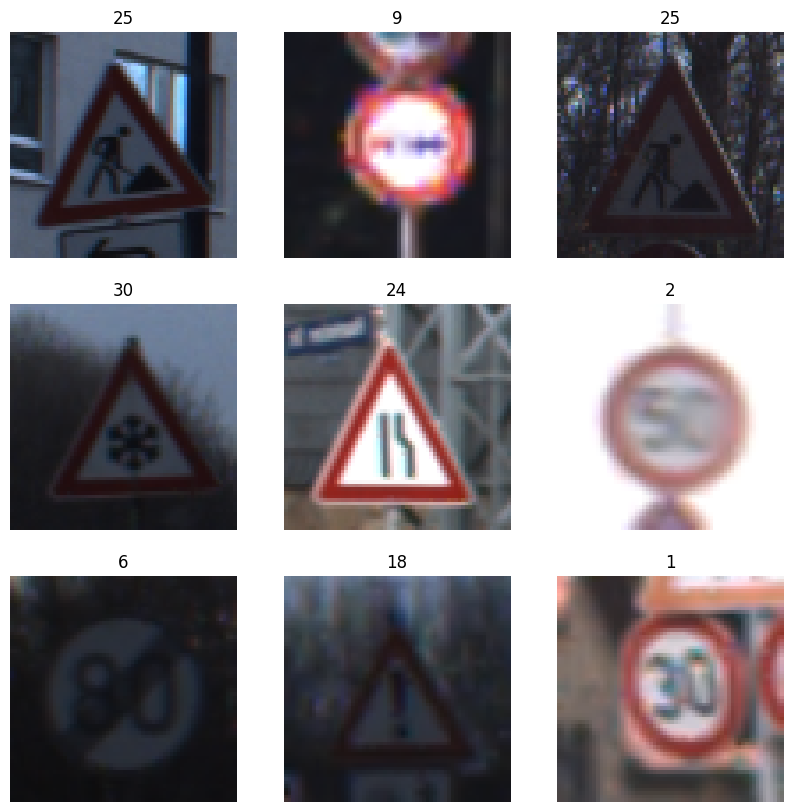

In [5]:
# visualize 9 images in 3x3 grid
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

indices = np.random.choice(len(train_images), 9)
for i, idx in enumerate(indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[idx])
    plt.title(train_labels[idx])
    plt.axis('off')

plt.show()

### Podjela na skup za treniranje i testiranje

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (31367, 64, 64, 3)
X_val shape: (7842, 64, 64, 3)
y_train shape: (31367,)
y_val shape: (7842,)


## Drugi skup podataka (domain change)

In [7]:
import h5py
import numpy as np
from PIL import Image
import os

# Path to the HDF5 file
hdf5_file_path = PREFIX / 'datasets' / 'traffic-signs-1-million-images-for-classification' / 'dataset_ts_original.hdf5'

# Output directory for extracted images
# output_dir = "extracted_images"
# os.makedirs(output_dir, exist_ok=True)

# Open the HDF5 file
new_domain_test_images_original = []
new_domain_test_labels = []

with h5py.File(hdf5_file_path, "r") as hdf:
    # Explore the structure
    print("Keys in the HDF5 file:", list(hdf.keys()))  # Shows the top-level groups/datasets
    new_domain_test_images_original = hdf['x_test'][:]
    new_domain_test_labels = hdf['y_test'][:]

Keys in the HDF5 file: ['x_test', 'x_train', 'x_validation', 'y_test', 'y_train', 'y_validation']


### Vizualizacija novog podatkovnog skupa

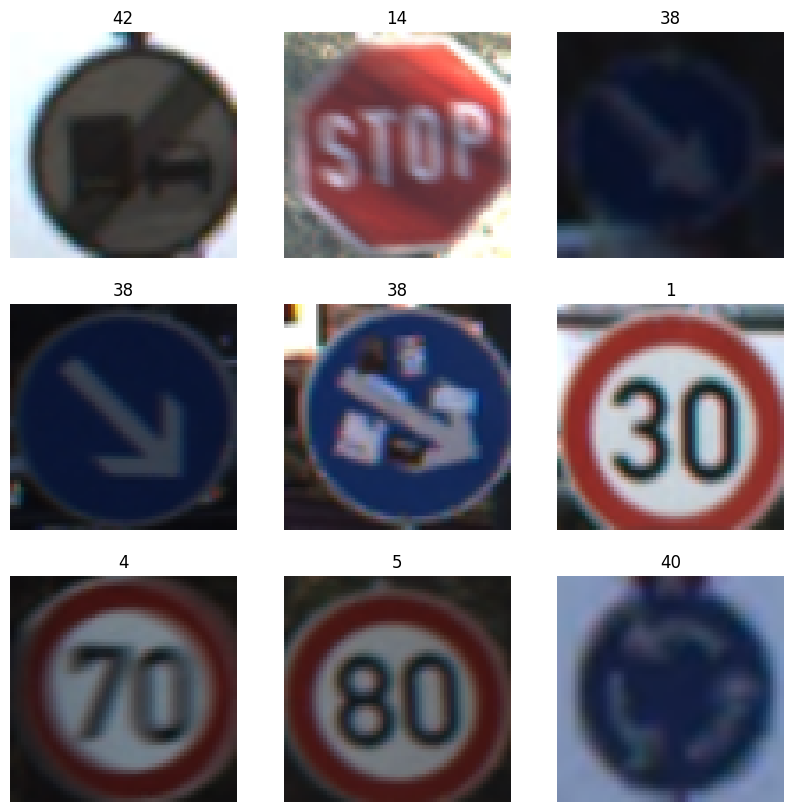

In [8]:
import cv2
import numpy as np

new_domain_test_images = []
for label, image in zip(new_domain_test_labels, new_domain_test_images_original):
  # image = cv2.imread(image)
  image = cv2.resize(image, (64, 64))
  # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = np.clip(image, 0, 255).astype(np.uint8)
  new_domain_test_images.append(image)

plt.figure(figsize=(10, 10))

indices = np.random.choice(len(new_domain_test_images), 9)
for i, idx in enumerate(indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(new_domain_test_images[idx])
    plt.title(new_domain_test_labels[idx])
    plt.axis('off')

plt.show()

## Treniranje modela

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np

class TrafficSignDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images # input, odnosno X
        self.labels = labels # output, odnosno y
        self.transform = transform # transformacija podataka

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx): # vrati odredeni X (transformirani) i y
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)), # zelimo 64x64
    transforms.ToTensor(), # pretvori u tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalizacija svih piksela
])

train_dataset = TrafficSignDataset(X_train, y_train, transform=transform)
val_dataset = TrafficSignDataset(X_val, y_val, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [10]:
class NewDomainTrafficSignDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images # input, odnosno X
        self.labels = labels # output, odnosno y
        self.transform = transform # transformacija podataka

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx): # vrati odredeni X (transformirani) i y
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)), # zelimo 64x64
    transforms.ToTensor(), # pretvori u tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalizacija svih piksela
])


new_domain_test_dataset = NewDomainTrafficSignDataset(new_domain_test_images, new_domain_test_labels, transform=transform)

batch_size = 64
new_domain_test_loader = DataLoader(new_domain_test_dataset, batch_size=batch_size, shuffle=False)

### Definiranje arhitekture modela

In [11]:
import torch.nn as nn
import torch

class TraffiKING(nn.Module):
    def __init__(self, num_classes=43):
        super(TraffiKING, self).__init__()

        self.layers = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, num_classes)
        )

    def forward(self, x):
        return self.layers(x)

### Training loop, postupak treniranja

In [12]:
from logger import Logger
from datetime import datetime
import sys

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, save_dir, epochs=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)  # prebacit model na cuda
    best_epoch = 0
    best_epoch_accuracy = 0

    current_time = datetime.now().strftime('%Y_%m_%d_%H_%M')
    log_dir = f'weights/{save_dir}/{current_time}'

    os.makedirs(log_dir, exist_ok=True)
    f = open(f'{log_dir}/log.txt', 'a')

    original_stdout = sys.stdout
    sys.stdout = Logger(sys.stdout, f)

    for epoch in range(epochs):
        model.train()  # model na trening mode
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device) # prebacit i podatke na cuda

            optimizer.zero_grad() # resetirat gradijente

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backprop, optimizer
            loss.backward()
            optimizer.step()

            # gubitak
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        scheduler.step()
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        # print epoha, gubitka, tocnosti
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}')

        model.eval()  # model na validation mode
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        print(f'Validation Accuracy: {val_acc:.2f}%')

        if val_acc > best_epoch_accuracy:
            best_epoch = epoch
            best_epoch_accuracy = val_acc
            torch.save(model.state_dict(), f'weights/{save_dir}/{current_time}/best_model.pt')
        print(f'BEST EPOCH: {best_epoch}, ACCURACY: {best_epoch_accuracy:.2f}%')


    torch.save(model.state_dict(), f'weights/{save_dir}/{current_time}/model.pt')
    sys.stdout = original_stdout
    f.close()

In [23]:
def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')


## Treniranje i evaulacija modela

In [14]:
import torch.optim as optim
from torch.optim import lr_scheduler

pretrained = False
mode = 'pretrained' if pretrained else 'random_init'

### TraffiKING

In [15]:
%pip install onnx

import torch.onnx
model = TraffiKING(num_classes=43)

# Export model to ONNX format
dummy_input = torch.randn(1, 3, 64, 64)
torch.onnx.export(model, dummy_input, "model.onnx")

Note: you may need to restart the kernel to use updated packages.


In [16]:
model = TraffiKING(num_classes=43)
criterion = nn.CrossEntropyLoss() # unakrsna entropija (strojno hehe)
optimizer = optim.Adam(model.parameters(), lr=0.001) # roko leni
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1) # smanjivanje lr-a svake 4 epohe

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, save_dir='TraffiKING')

Epoch [1/20], Loss: 1.4379, Accuracy: 66.44%, LR: 0.001000
Validation Accuracy: 81.65%
BEST EPOCH: 0, ACCURACY: 81.65%
Epoch [2/20], Loss: 0.3511, Accuracy: 91.28%, LR: 0.001000
Validation Accuracy: 93.27%
BEST EPOCH: 1, ACCURACY: 93.27%
Epoch [3/20], Loss: 0.2176, Accuracy: 94.81%, LR: 0.001000
Validation Accuracy: 92.67%
BEST EPOCH: 1, ACCURACY: 93.27%
Epoch [4/20], Loss: 0.1896, Accuracy: 95.77%, LR: 0.000100
Validation Accuracy: 94.80%
BEST EPOCH: 3, ACCURACY: 94.80%
Epoch [5/20], Loss: 0.0312, Accuracy: 99.09%, LR: 0.000100
Validation Accuracy: 97.13%
BEST EPOCH: 4, ACCURACY: 97.13%
Epoch [6/20], Loss: 0.0141, Accuracy: 99.65%, LR: 0.000100
Validation Accuracy: 97.31%
BEST EPOCH: 5, ACCURACY: 97.31%
Epoch [7/20], Loss: 0.0107, Accuracy: 99.76%, LR: 0.000100
Validation Accuracy: 97.44%
BEST EPOCH: 6, ACCURACY: 97.44%
Epoch [8/20], Loss: 0.0081, Accuracy: 99.83%, LR: 0.000010
Validation Accuracy: 97.53%
BEST EPOCH: 7, ACCURACY: 97.53%
Epoch [9/20], Loss: 0.0063, Accuracy: 99.87%, LR

### ResNet-18

In [17]:
from torchvision.models import resnet18, ResNet18_Weights

if pretrained: # ImageNet pretrained
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
else:  # Random weights
    model = resnet18(weights=None)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, save_dir=f'ResNet18/{mode}')

Epoch [1/20], Loss: 0.4990, Accuracy: 86.17%, LR: 0.001000
Validation Accuracy: 94.20%
BEST EPOCH: 0, ACCURACY: 94.20%
Epoch [2/20], Loss: 0.0782, Accuracy: 97.54%, LR: 0.001000
Validation Accuracy: 96.84%
BEST EPOCH: 1, ACCURACY: 96.84%
Epoch [3/20], Loss: 0.0474, Accuracy: 98.54%, LR: 0.001000
Validation Accuracy: 97.46%
BEST EPOCH: 2, ACCURACY: 97.46%
Epoch [4/20], Loss: 0.0310, Accuracy: 99.02%, LR: 0.000100
Validation Accuracy: 96.74%
BEST EPOCH: 2, ACCURACY: 97.46%
Epoch [5/20], Loss: 0.0072, Accuracy: 99.80%, LR: 0.000100
Validation Accuracy: 99.62%
BEST EPOCH: 4, ACCURACY: 99.62%
Epoch [6/20], Loss: 0.0014, Accuracy: 99.99%, LR: 0.000100
Validation Accuracy: 99.66%
BEST EPOCH: 5, ACCURACY: 99.66%
Epoch [7/20], Loss: 0.0009, Accuracy: 100.00%, LR: 0.000100
Validation Accuracy: 99.68%
BEST EPOCH: 6, ACCURACY: 99.68%
Epoch [8/20], Loss: 0.0010, Accuracy: 100.00%, LR: 0.000010
Validation Accuracy: 99.66%
BEST EPOCH: 6, ACCURACY: 99.68%
Epoch [9/20], Loss: 0.0006, Accuracy: 99.99%, 

### EfficientNet

In [18]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

if pretrained:  # ImageNet pretrained
    model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
else:  # Random weights
    model = efficientnet_b0(weights=None)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, save_dir=f'EfficientNetB0/{mode}')

Epoch [1/20], Loss: 1.4541, Accuracy: 59.46%, LR: 0.001000
Validation Accuracy: 90.45%
BEST EPOCH: 0, ACCURACY: 90.45%
Epoch [2/20], Loss: 0.2229, Accuracy: 93.24%, LR: 0.001000
Validation Accuracy: 95.87%
BEST EPOCH: 1, ACCURACY: 95.87%
Epoch [3/20], Loss: 0.1222, Accuracy: 96.41%, LR: 0.001000
Validation Accuracy: 96.61%
BEST EPOCH: 2, ACCURACY: 96.61%
Epoch [4/20], Loss: 0.0918, Accuracy: 97.30%, LR: 0.000100
Validation Accuracy: 97.83%
BEST EPOCH: 3, ACCURACY: 97.83%
Epoch [5/20], Loss: 0.0230, Accuracy: 99.37%, LR: 0.000100
Validation Accuracy: 99.23%
BEST EPOCH: 4, ACCURACY: 99.23%
Epoch [6/20], Loss: 0.0112, Accuracy: 99.70%, LR: 0.000100
Validation Accuracy: 99.22%
BEST EPOCH: 4, ACCURACY: 99.23%
Epoch [7/20], Loss: 0.0074, Accuracy: 99.81%, LR: 0.000100
Validation Accuracy: 99.32%
BEST EPOCH: 6, ACCURACY: 99.32%
Epoch [8/20], Loss: 0.0057, Accuracy: 99.87%, LR: 0.000010
Validation Accuracy: 99.36%
BEST EPOCH: 7, ACCURACY: 99.36%
Epoch [9/20], Loss: 0.0043, Accuracy: 99.92%, LR

### MobileNetV2

In [19]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

if pretrained:  # ImageNet pretrained
    model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
else:
    model = mobilenet_v2(weights=None)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, save_dir=f'MobileNetV2/{mode}')

Epoch [1/20], Loss: 1.7294, Accuracy: 48.90%, LR: 0.001000
Validation Accuracy: 81.32%
BEST EPOCH: 0, ACCURACY: 81.32%


Epoch [2/20], Loss: 0.3469, Accuracy: 88.85%, LR: 0.001000
Validation Accuracy: 92.73%
BEST EPOCH: 1, ACCURACY: 92.73%
Epoch [3/20], Loss: 0.1772, Accuracy: 94.54%, LR: 0.001000
Validation Accuracy: 96.65%
BEST EPOCH: 2, ACCURACY: 96.65%
Epoch [4/20], Loss: 0.1065, Accuracy: 96.77%, LR: 0.000100
Validation Accuracy: 95.46%
BEST EPOCH: 2, ACCURACY: 96.65%
Epoch [5/20], Loss: 0.0332, Accuracy: 99.15%, LR: 0.000100
Validation Accuracy: 98.83%
BEST EPOCH: 4, ACCURACY: 98.83%
Epoch [6/20], Loss: 0.0118, Accuracy: 99.67%, LR: 0.000100
Validation Accuracy: 98.88%
BEST EPOCH: 5, ACCURACY: 98.88%
Epoch [7/20], Loss: 0.0072, Accuracy: 99.84%, LR: 0.000100
Validation Accuracy: 99.02%
BEST EPOCH: 6, ACCURACY: 99.02%
Epoch [8/20], Loss: 0.0056, Accuracy: 99.86%, LR: 0.000010
Validation Accuracy: 99.06%
BEST EPOCH: 7, ACCURACY: 99.06%
Epoch [9/20], Loss: 0.0047, Accuracy: 99.94%, LR: 0.000010
Validation Accuracy: 98.99%
BEST EPOCH: 7, ACCURACY: 99.06%
Epoch [10/20], Loss: 0.0033, Accuracy: 99.95%, L

### DenseNet121

In [20]:
from torchvision.models import densenet121, DenseNet121_Weights

if pretrained:  # ImageNet pretrained
    model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
else:
    model = densenet121(weights=None)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, save_dir=f'DenseNet121/{mode}')

Epoch [1/20], Loss: 1.0953, Accuracy: 68.00%, LR: 0.001000
Validation Accuracy: 91.99%
BEST EPOCH: 0, ACCURACY: 91.99%
Epoch [2/20], Loss: 0.1232, Accuracy: 96.27%, LR: 0.001000
Validation Accuracy: 91.38%
BEST EPOCH: 0, ACCURACY: 91.99%
Epoch [3/20], Loss: 0.0673, Accuracy: 97.98%, LR: 0.001000
Validation Accuracy: 98.55%
BEST EPOCH: 2, ACCURACY: 98.55%
Epoch [4/20], Loss: 0.0408, Accuracy: 98.81%, LR: 0.000100
Validation Accuracy: 97.25%
BEST EPOCH: 2, ACCURACY: 98.55%
Epoch [5/20], Loss: 0.0082, Accuracy: 99.79%, LR: 0.000100
Validation Accuracy: 99.69%
BEST EPOCH: 4, ACCURACY: 99.69%
Epoch [6/20], Loss: 0.0026, Accuracy: 99.97%, LR: 0.000100
Validation Accuracy: 99.83%
BEST EPOCH: 5, ACCURACY: 99.83%
Epoch [7/20], Loss: 0.0016, Accuracy: 99.98%, LR: 0.000100
Validation Accuracy: 99.82%
BEST EPOCH: 5, ACCURACY: 99.83%
Epoch [8/20], Loss: 0.0009, Accuracy: 100.00%, LR: 0.000010
Validation Accuracy: 99.85%
BEST EPOCH: 7, ACCURACY: 99.85%
Epoch [9/20], Loss: 0.0008, Accuracy: 99.99%, L

# Promjena domene

### TraffiKING

In [25]:
model = TraffiKING(num_classes=43)
model.load_state_dict(torch.load(PREFIX / 'weights' / 'TraffiKING' / '2025_01_14_10_13' / 'best_model.pt', weights_only=True))
evaluate_model(model, new_domain_test_loader)

Test Accuracy: 64.32%


### ResNet18

In [ ]:
from torchvision.models import resnet18

model = resnet18(weights=None)
model.load_state_dict(torch.load(PREFIX / 'weights' / 'ResNet18' / 'random_init' / '2025_01_14_11_22' / 'best_model.pt', weights_only=True))
evaluate_model(model, new_domain_test_loader)

Test Accuracy: 90.23%


### EfficientNet

In [28]:
from torchvision.models import efficientnet_b0

model = efficientnet_b0(weights=None)
model.load_state_dict(torch.load(PREFIX / 'weights' / 'EfficientNetB0' / 'random_init' / '2025_01_14_11_31' / 'best_model.pt', weights_only=True))
evaluate_model(model, new_domain_test_loader)

Test Accuracy: 83.64%


### MobileNetV2

In [29]:
from torchvision.models import mobilenet_v2

model = mobilenet_v2(weights=None)
model.load_state_dict(torch.load(PREFIX / 'weights' / 'MobileNetV2' / 'random_init' / '2025_01_14_11_42' / 'best_model.pt', weights_only=True))
evaluate_model(model, new_domain_test_loader)

Test Accuracy: 84.51%


### DenseNet121

In [31]:
from torchvision.models import densenet121

model = densenet121(weights=None)
model.load_state_dict(torch.load(PREFIX / 'weights' / 'DenseNet121' / 'random_init' / '2025_01_14_11_51' / 'best_model.pt', weights_only=True))
evaluate_model(model, new_domain_test_loader)

Test Accuracy: 93.25%


In [30]:
!zip -r /content/TraffiKING/weights.zip /content/TraffiKING/weights

  adding: content/TraffiKING/weights/ (stored 0%)
  adding: content/TraffiKING/weights/MobileNetV2/ (stored 0%)
  adding: content/TraffiKING/weights/MobileNetV2/pretrained/ (stored 0%)
  adding: content/TraffiKING/weights/MobileNetV2/pretrained/2025_01_14_10_42/ (stored 0%)
  adding: content/TraffiKING/weights/MobileNetV2/pretrained/2025_01_14_10_42/log.txt (deflated 85%)
  adding: content/TraffiKING/weights/MobileNetV2/pretrained/2025_01_14_10_42/best_model.pt (deflated 8%)
  adding: content/TraffiKING/weights/MobileNetV2/pretrained/2025_01_14_10_42/model.pt (deflated 8%)
  adding: content/TraffiKING/weights/MobileNetV2/random_init/ (stored 0%)
  adding: content/TraffiKING/weights/MobileNetV2/random_init/2025_01_14_11_42/ (stored 0%)
  adding: content/TraffiKING/weights/MobileNetV2/random_init/2025_01_14_11_42/log.txt (deflated 84%)
  adding: content/TraffiKING/weights/MobileNetV2/random_init/2025_01_14_11_42/best_model.pt (deflated 9%)
  adding: content/TraffiKING/weights/MobileNetV2